# Classificação de imagens de amostras geológicas usando a técnica de transfer learning aplicada na resNet50.

#### Aluno: [Fredy Giovany Osorio Gutiérrez](https://github.com/fr3dyos).
#### Orientador: [Leonardo Forero Mendonza](https://github.com/leofome8).

---

Trabalho apresentado ao curso [BI MASTER](https://ica.puc-rio.ai/bi-master) como pré-requisito para conclusão de curso e obtenção de crédito na disciplina "Projetos de Sistemas Inteligentes de Apoio à Decisão".

- [Link para o código](TL_geological_image_similarity_com_ResNet50.ipynb).

---


### Resumo

Este projeto tem como foco a aplicação da técnica de transfer learning utilizando a ResNet50 na classificação de amostras geológicas por meio de imagens. O objetivo principal é avaliar a eficácia e precisão da rede neural pré-treinada na identificação de diferentes tipos de rochas, minerais e materiais geológicos. O estudo busca fornecer conclusões relevantes sobre a aplicação de inteligência artificial em geologia e ciências da terra.



### 1. Introdução

A inteligência artificial tem sido amplamente aplicada em diversas áreas, incluindo a geologia. A classificação de imagens de amostras geológicas é uma tarefa importante para identificar e caracterizar diferentes tipos de rochas, minerais e outros materiais geológicos. No entanto, essa tarefa pode ser desafiadora devido à grande variedade de características e texturas presentes nas imagens geológicas.

Uma técnica eficiente para a classificação de imagens é o uso de transfer learning, que consiste em utilizar uma rede neural já pré-treinada em uma grande quantidade de dados e adaptá-la para uma tarefa específica. A ResNet50 é uma rede neural profunda que obteve excelentes resultados em tarefas de classificação de imagens em geral.

Nesta monografia, será apresentado um estudo sobre a aplicação de transfer learning utilizando a ResNet50 para a classificação de imagens de amostras geológicas. Serão descritas as etapas do pré-processamento de dados, treinamento e teste da rede neural, além da análise dos resultados obtidos. A importância da escolha dos parâmetros de treinamento e a avaliação da performance da rede serão discutidas em detalhes.

Por fim, serão apresentadas as conclusões sobre a eficácia da técnica de transfer learning utilizando a ResNet50 para a classificação de imagens de amostras geológicas, bem como as possibilidades de aplicação em outras áreas da geologia e ciências da terra.


### 2. Modelagem

Primeiramente, foi necessário preparar o conjunto de dados de amostras geológicas, provenientes do repositório de [*geological image similarity*](https://www.kaggle.com/datasets/tanyadayanand/geological-image-similarity) do kaggle para alimentar a rede neural.

In [ ]:
! pip install -q kaggle

In [ ]:
! mkdir ~/.kaggle
! mv kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
# kaggle.json é um arquivo chave que permite descarregar as informações direitamente od kaggle
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d tanyadayanand/geological-image-similarity

100% 33.6M/33.6M [00:02<00:00, 23.9MB/s]
100% 33.6M/33.6M [00:02<00:00, 15.1MB/s]


In [ ]:
! unzip -nq geological-image-similarity.zip -d .

Usou-se uma utilidade de processamento de dados do keras chamada "*image_dataset_from_directory*". Esta ferramenta pega as imagens desde o diretório, as ordena por pastas (que representam classes), redimensiona as imagens. Tem como saida tensores com tamanhos de batch especificos prontos para fazer treinamento e validação.

As 29998 imagens de amostras geológicas estão separadas em 6 classes, cada uma em sua propria pasta:

*   Andesite 
*   Gneiss 
*   Marble 
*   Quartzite 
*   Rhyolite 
*   Schist

In [ ]:
import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing import image_dataset_from_directory

# Tamanho das imagens
img_height, img_width = 48, 48
batch_size = 32
data_directory='geological_similarity'


train_ds = image_dataset_from_directory(     
    seed=77,
    directory=data_directory,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset='training',
    label_mode ='categorical'
    )

Found 29998 files belonging to 6 classes.
Using 23999 files for training.


Usando a mesma ferramenta foi criado o dataset de validação

In [ ]:
validation_ds = image_dataset_from_directory(
    data_directory,
    validation_split=0.2,
    subset="validation",
    seed=77,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode ='categorical'
    )

Found 29998 files belonging to 6 classes.
Using 5999 files for validation.


#### Funcionalidades

Se criaram algumas funções que ajudam a mostrar as imagens do dataset e sua respeitiva classe

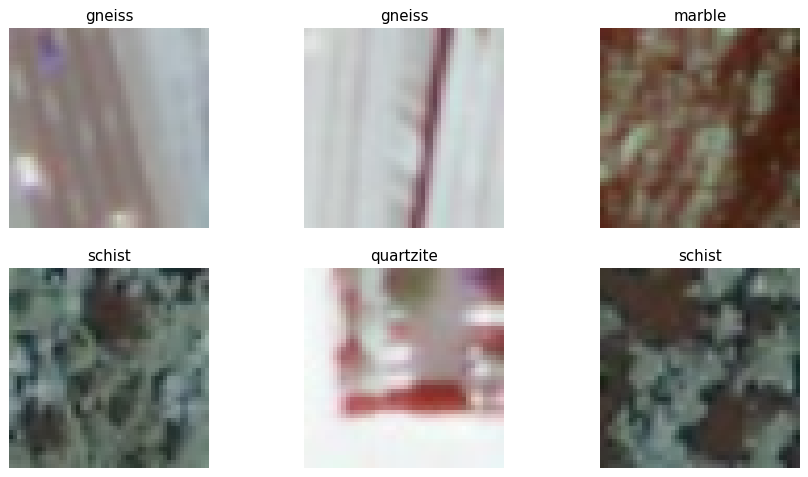

In [ ]:
import matplotlib.pyplot as plt
import os

# Na libreria de image_dataset_from_directory as classes são organizadas segundo 
# aparecem no directório usando os.walk. 

for root, dirs, files in os.walk("geological_similarity", topdown=False):
   classnames=[name for name in dirs]

# cname devolve os nomes das as classes segundo o vetor de classificação

def cname(cat,classnames):
  index = np.argmax(cat)
  return classnames[index]

# Showtest amostra 6 imagens aleatórias com suas respeitivas classes dada algum dataset

def showtest(dataset,classnames=['none','none','none','none','none']):
  plt.figure(figsize=(12, 10),dpi=90)

  for images, labels in dataset.take(1):
    for var in range(6):
      ax = plt.subplot(3, 3, var + 1)
      plt.imshow(images[var].numpy().astype("uint8"))
      plt.title(cname(labels[var].numpy().astype("int32"),classnames) )
      plt.axis("off")

showtest(train_ds,classnames)

#### Configuração do modelo

A rede neuronal foi baseada no Resnet50 apartir da técnica de trasnfer learning. 
Para isso usamos as librarias do tensorflow e keras para descarregar o modelo base.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50


Se cria o modelo confugurando a resNet50 colocando os tamanhos das imagens e usando os pesos da imagenet.

In [ ]:
model = Sequential()

pretrained_model_for_demo= ResNet50(include_top=False,
                   input_shape=(img_height, img_width,3),
                   pooling='avg',classes=6,
                   weights='imagenet')

for each_layer in pretrained_model_for_demo.layers:
  each_layer.trainable=False

model.add(pretrained_model_for_demo)

Neste caso foi adicionada uma camada de 1024 neuronios Dense e uma camada de saida Danse de 6 neuronios representando cada uma uma classe de rocha. 

In [ ]:
from tensorflow.keras.layers import Flatten,Dense

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(len(classnames), activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 25,692,038
Trainable params: 2,104,326
Non-trainable params: 23,587,712
_________________________________________________________________


#### Treinamento

Após a configuração da rede, é possível realizar o treinamento utilizando o conjunto de dados de amostras geológicas. Durante o treinamento, é importante monitorar as métricas de desempenho da rede, como acurácia e perda. Para isto foram usados os callbacks *EarlyStopping* e *ReduceLROnPlateau* para detener o treinamento no momento de ter ganhos não significativos junto com o *ModelCheckpoint* que permite salvar o modelo com melhor eficiência. 


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

es = EarlyStopping(patience=8)
rlr = ReduceLROnPlateau(monitor='val_loss', patience=6)
mc = ModelCheckpoint(filepath='best_{epoch:03d}-{val_loss:.4f}.h5', save_best_only=True) 

history = model.fit(train_ds, validation_data=validation_ds, epochs=40, callbacks=[rlr, es, mc])

Epoch 1/40
750/750 [==============================] - ETA: 0s - loss: 0.1891 - accuracy: 0.9388

/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


750/750 [==============================] - 33s 35ms/step - loss: 0.1891 - accuracy: 0.9388 - val_loss: 0.1189 - val_accuracy: 0.9572 - lr: 0.0010
Epoch 2/40
750/750 [==============================] - 23s 31ms/step - loss: 0.0846 - accuracy: 0.9709 - val_loss: 0.1098 - val_accuracy: 0.9637 - lr: 0.0010
Epoch 3/40
750/750 [==============================] - 23s 30ms/step - loss: 0.0598 - accuracy: 0.9799 - val_loss: 0.1328 - val_accuracy: 0.9648 - lr: 0.0010
Epoch 4/40
750/750 [==============================] - 24s 32ms/step - loss: 0.0514 - accuracy: 0.9830 - val_loss: 0.1374 - val_accuracy: 0.9655 - lr: 0.0010
Epoch 5/40
750/750 [==============================] - 24s 32ms/step - loss: 0.0560 - accuracy: 0.9829 - val_loss: 0.1482 - val_accuracy: 0.9672 - lr: 0.0010
Epoch 6/40
750/750 [==============================] - 24s 32ms/step - loss: 0.0411 - accuracy: 0.9875 - val_loss: 0.1615 - val_accuracy: 0.9680 - lr: 0.0010
Epoch 7/40
750/750 [==============================] - 23s 30ms/step -

Foram criadas as figuras do historico de treinamento, tanto de acurácia como das perdas.

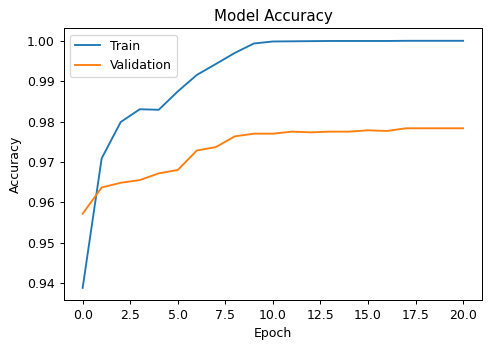

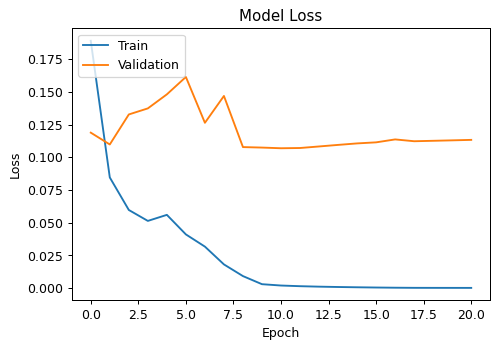

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4), dpi=90)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure(figsize=(6, 4), dpi=90)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


### 3. Resultados

Foi criada mais uma funcionalidade para apresentar os resultados testando aleatóriamente os datasets. 

In [ ]:
def showtestmodel(model,ds,classnames=['none','none','none','none','none'],n=6):
  
  plt.figure(figsize=(9, int(5*np.ceil(n/3))), dpi=90)

  for images, labels in ds.take(1):
    print('\tpred','\t','real')
    for var in range(n):
      ax = plt.subplot(int(np.ceil(n/3)),3, var + 1)
      prediction = model.predict(images[var].numpy().astype("uint8").reshape(-1, img_height, img_width, 3))
      pred =np.round(prediction[0]).astype("int32")
      real= labels[var].numpy().astype("int32")
      check,col = ['\u2713','blue'] if cname(pred,classnames)==cname(real,classnames) else ['\u2717','red']
      print('[',var+1,']',pred,real,check)
      plt.imshow(images[var].numpy().astype("uint8"))
      try:
        plt.title('P:'+cname(pred,classnames)+' | R:'+cname(real,classnames),color=col)
      except:
        plt.title('sem predição',color=col)
        print(prediction[0])
      plt.axis("off")


Teste do modelo desde o dataset de treinamento.

	pred 	 real
[ 1 ] [0 0 0 0 1 0] [0 0 0 0 1 0] ✓
[ 2 ] [0 0 1 0 0 0] [0 0 1 0 0 0] ✓
[ 3 ] [0 0 0 0 0 1] [0 0 0 0 0 1] ✓
[ 4 ] [0 0 1 0 0 0] [0 0 1 0 0 0] ✓
[ 5 ] [0 0 0 0 0 1] [0 0 0 0 0 1] ✓
[ 6 ] [0 1 0 0 0 0] [0 1 0 0 0 0] ✓


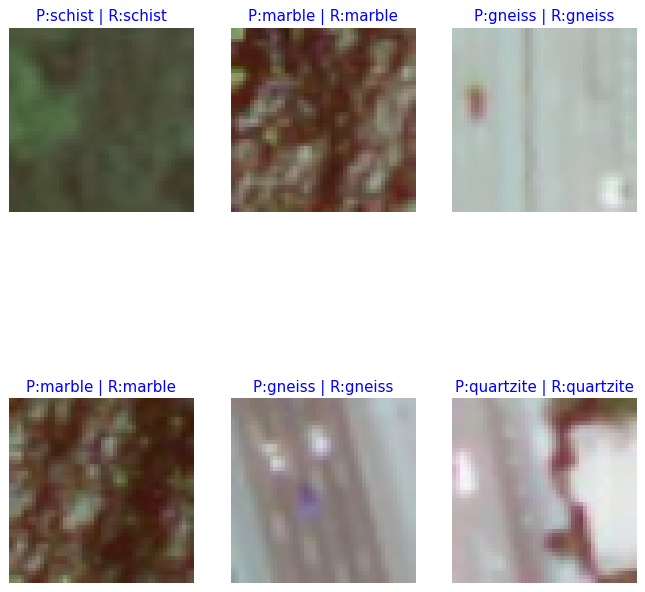

In [ ]:
showtestmodel(model,train_ds,classnames)

Teste do modelo desde o dataset de Validação. 

	pred 	 real
[ 1 ] [0 0 1 0 0 0] [0 0 1 0 0 0] ✓
[ 2 ] [1 0 0 0 0 0] [1 0 0 0 0 0] ✓
[ 3 ] [0 0 0 1 0 0] [0 0 0 1 0 0] ✓
[ 4 ] [0 0 1 0 0 0] [0 0 1 0 0 0] ✓
[ 5 ] [0 1 0 0 0 0] [0 1 0 0 0 0] ✓
[ 6 ] [0 0 0 0 0 1] [0 0 0 0 0 1] ✓


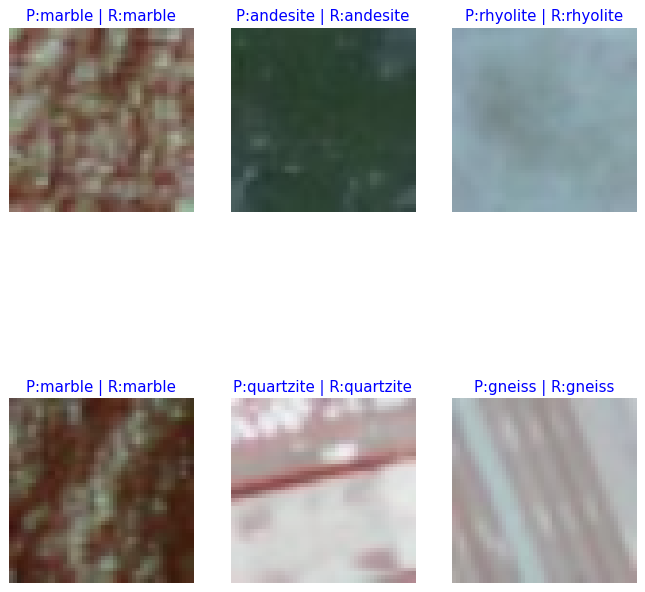

In [ ]:
showtestmodel(model,validation_ds,classnames,n=6)

Foi criada a figura de matriz de confusão para avaliar o modelo. Ela mostra como cada classe foi classificada pelo modelo.

Podemos observar que a maioria das amostras foi classificada corretamente, com exceção de algumas amostras de schist e gneiss que foram classificadas como andesite (38 e 11 amostras respectivamente), e algumas amostras de andesite que foram classificadas como schist (17 amostras).


A partir da matriz de confusão, podemos calcular as métricas de desempenho, como a acurácia, recall e F1-score para avaliar o desempenho geral do modelo. Ao calcular estas métricas encontramos um valor igual para todas de 0.978, o que representa que acima do 97% das amostras no dataset de validação foram classificadas corretamente pelo modelo proposto.


In [ ]:
# Matriz de confusão
from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix
import seaborn as sns

def classification(y,classnames=classnames):
  classes =[]
  for i in range(y.shape[0]): 
    classes.append(cname(y[i],classnames))
  return classes

val_X = []
real = []
for batch in validation_ds:
  val_X.append(batch[0])
  real.append(batch[1])

val_X = np.array(np.concatenate(val_X, axis=0))
realvalues = np.array(np.concatenate(real, axis=0))
prediction = model.predict(val_X)

pred=classification(prediction)
real=classification(realvalues)

In [ ]:
from mlxtend.evaluate import confusion_matrix
import seaborn as sns

confMatrix = confusion_matrix(pred, real,binary =False)
cM = pd.DataFrame(confMatrix, index=classnames, columns=classnames)
print('\tMatriz de Confusão\n',cM)

	Matriz de Confusão
            andesite  quartzite  marble  rhyolite  schist  gneiss
andesite        949          1       0         1      38      11
quartzite         1        954       0        13       3       0
marble            0          1    1028         0       0       0
rhyolite          0         17       0       989       5       0
schist           24          0       0         2     949       1
gneiss           12          0       0         0       0    1000


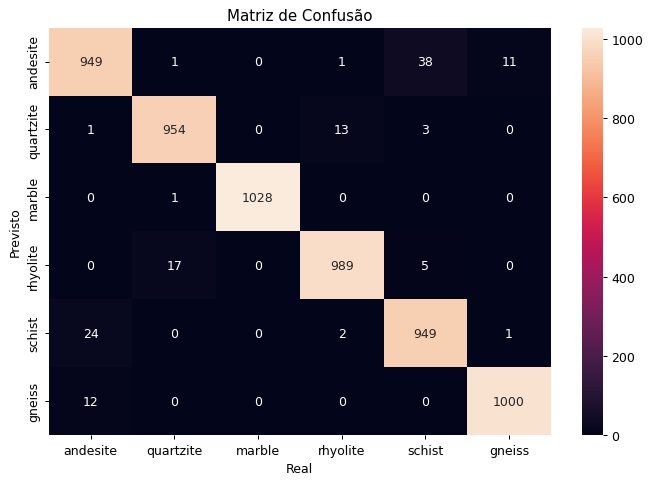

In [ ]:

plt.figure(figsize=(9, 6), dpi=90)
ax = plt.subplot()
sns.heatmap(confMatrix, annot=True, fmt=".0f")
plt.xlabel('Real')
plt.ylabel('Previsto')
plt.title('Matriz de Confusão')
# Colocar os nomes
ax.xaxis.set_ticklabels(classnames) 
ax.yaxis.set_ticklabels(classnames)
plt.show()

Foram calculadas as métricas

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf


# Calculo das métricas
accuracy = accuracy_score(real, pred)
precision = precision_score(real, pred, average='weighted')
recall = recall_score(real, pred, average='weighted')
f1 = f1_score(real, pred, average='weighted')

print(f"Acurácia: {accuracy:.3f}")
print(f"Precisão: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

Acurácia: 0.978
Precisão: 0.978
Recall: 0.978
F1-Score: 0.978


### 4. Conclusões

O modelo tem um desempenho geral muito bom: a acurácia de 0,978 indica que o modelo classifica corretamente a maioria das amostras. Com exceção de algumas amostras de andesite e quartzite que foram classificadas incorretamente.

A partir da matriz de confusão podemos concluir que algumas classes têm melhor desempenho do que outras, como marble e gneiss, que tiveram um desempenho excelente, com quase todas as amostras sendo classificadas corretamente. Por outro lado, outras classes, como andesite e schist, tiveram um desempenho um pouco pior, com algumas amostras sendo classificadas incorretamente, o que podem nos levar à conclusão a que são classes muito parecidas, porém, o valor alto da acurácia sugere que o modelo funciona da maneira apropriada na grande maioria dos casos.

A técnica de Transfer Learning é um método de aprendizado de máquina que permite reutilizar modelos de redes neurais pré-treinados em outras tarefas, com o objetivo de economizar tempo e recursos no processo de treinamento. Ao utilizar a ResNet50 como uma rede neural pré-treinada, o modelo pode aproveitar o conhecimento adquirido em treinamentos anteriores e ajustá-lo para resolver problemas de classificação específicos, como o de amostras geológicas.

Além disso, a utilização de Transfer Learning permitiu que o modelo reduzisse o consumo de recursos computacionais disponíveis, tornando-o mais eficiente e acessível. Isso é particularmente importante em aplicações de aprendizado de máquina que exigem grande capacidade de processamento e armazenamento, como é o caso de muitos modelos de visão computacional.

Por fim, a capacidade do modelo de classificar com sucesso amostras geológicas demonstra a sua relevância e eficácia como uma ferramenta poderosa no mundo moderno. O uso de modelos de inteligência artificial pode ser benéfico em diversas áreas, incluindo a análise de imagens, diagnóstico médico e previsão de tendências de mercado, entre outras aplicações.
